<a href="https://colab.research.google.com/github/Jingqi-Wang0416/MUSA-6950-Final-Project/blob/main/Final_Project_Jingqi_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
# Load Trolley Routes
trolley = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Miami/Miami_Trolley_Routes.geojson").to_crs(epsg=3857)

# Create Trolley Buffer (300m)
trolley_buffer = trolley.buffer(300).unary_union

<ipython-input-4-99c172bc39b6>:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  trolley_buffer = trolley.buffer(300).unary_union


In [ ]:
# Define study area bounding box
xmin, ymin, xmax, ymax = trolley.total_bounds

# Generate random points
np.random.seed(42)
num_points = 3000
random_x = np.random.uniform(xmin, xmax, num_points)
random_y = np.random.uniform(ymin, ymax, num_points)

random_points = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in zip(random_x, random_y)], crs="EPSG:3857")

In [ ]:
# Label: 1 if within 300m of trolley route, else 0
random_points["covered"] = random_points.geometry.apply(lambda x: x.within(trolley_buffer))
random_points["covered"] = random_points["covered"].astype(int)

In [ ]:
# Use X, Y coordinates as features
random_points["x"] = random_points.geometry.x
random_points["y"] = random_points.geometry.y

X = random_points[["x", "y"]]
y = random_points["covered"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=1)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       689
           1       0.94      0.90      0.92       211

    accuracy                           0.96       900
   macro avg       0.95      0.94      0.95       900
weighted avg       0.96      0.96      0.96       900



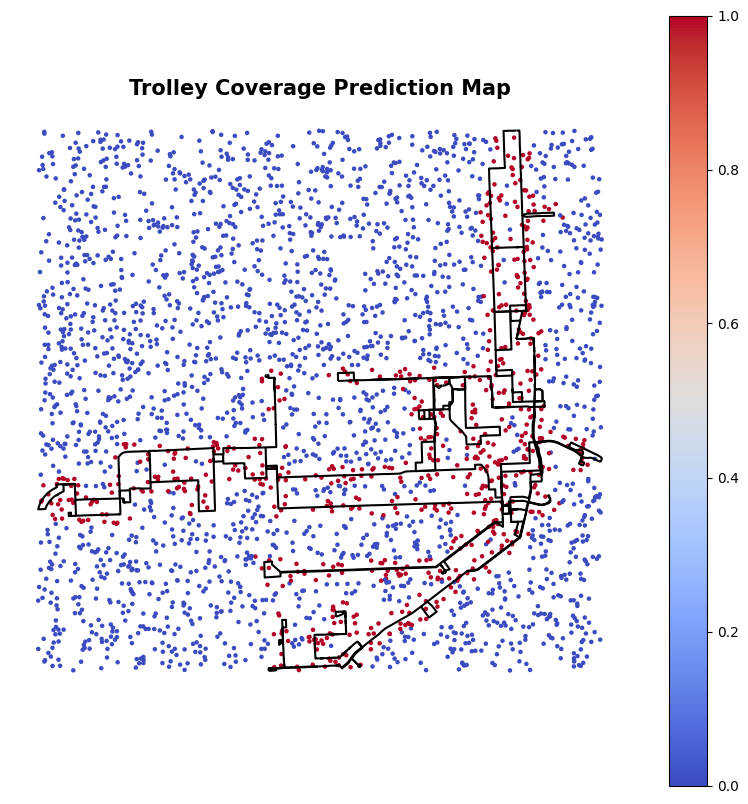

In [ ]:
# Predict over all points
y_all_pred = clf.predict(X)

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))
background = random_points.copy()
background["predicted"] = y_all_pred

background.plot(column="predicted", cmap="coolwarm", markersize=5, legend=True, ax=ax)
trolley.plot(ax=ax, color="black", linewidth=1.5)

plt.title("Trolley Coverage Prediction Map", fontsize=15, fontweight="bold")
plt.axis("off")
plt.show()

In [ ]:
# Predict probabilities instead of hard labels
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Classify based on threshold (e.g., 0.5)
predicted_cover = y_pred_proba > 0.5

# Calculate coverage rate
coverage_rate = predicted_cover.sum() / len(predicted_cover)
print(f"Predicted Trolley Coverage Rate: {coverage_rate:.2%}")

Predicted Trolley Coverage Rate: 22.56%


In [ ]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load landmarks with known buffer coverage
landmarks = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Miami/Landmarks.geojson").to_crs("EPSG:3857")

# Load trolley routes and create 300m buffer
trolley = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Miami/Miami_Trolley_Routes.geojson").to_crs("EPSG:3857")
trolley_buffer = trolley.buffer(300)
trolley_union = trolley_buffer.unary_union

# Add "covered" label based on 300m buffer
landmarks["covered"] = landmarks.geometry.apply(lambda pt: pt.within(trolley_union)).astype(int)


<ipython-input-13-8f97bf1d704e>:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  trolley_union = trolley_buffer.unary_union


In [ ]:
# Use coordinate-based features for prediction
coords = np.array([[pt.x, pt.y] for pt in landmarks.geometry])

# Predict probabilities and classes
y_pred_proba = clf.predict_proba(coords)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)
y_true = landmarks["covered"].values


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Accuracy and confusion matrix
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Accuracy: 0.9359477124183007
Confusion Matrix:
[[269  27]
 [ 22 447]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       296
           1       0.94      0.95      0.95       469

    accuracy                           0.94       765
   macro avg       0.93      0.93      0.93       765
weighted avg       0.94      0.94      0.94       765



In [ ]:
# Load neighborhood file and spatial join
neighborhoods = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Miami/Miami_Neighborhoods_Shapefile.geojson").to_crs("EPSG:3857")
landmarks["y_pred"] = y_pred

landmarks_with_neigh = gpd.sjoin(landmarks, neighborhoods, how="left", predicate="within")

# Group by neighborhood label
neigh_stats = landmarks_with_neigh.groupby("LABEL").agg(
    actual_covered=("covered", "mean"),
    predicted_covered=("y_pred", "mean"),
    count=("LMNAME", "count")
).reset_index().sort_values(by="count", ascending=False)

# Show top rows
neigh_stats.head(10)


,LABEL,actual_covered,predicted_covered,count
21,Civic Center,0.981818,1.000000,55
19,CBD,1.000000,0.980000,50
35,Government Center,0.676471,0.764706,34
36,Grove Center,1.000000,1.000000,27
76,Santa Clara,0.000000,0.000000,21
37,Hadley Park,0.000000,0.000000,18
71,Parkwest,0.444444,0.611111,18
28,East Little Havana,0.705882,0.705882,17
33,Flagami,1.000000,1.000000,15
56,Miami Avenue,0.923077,1.000000,13


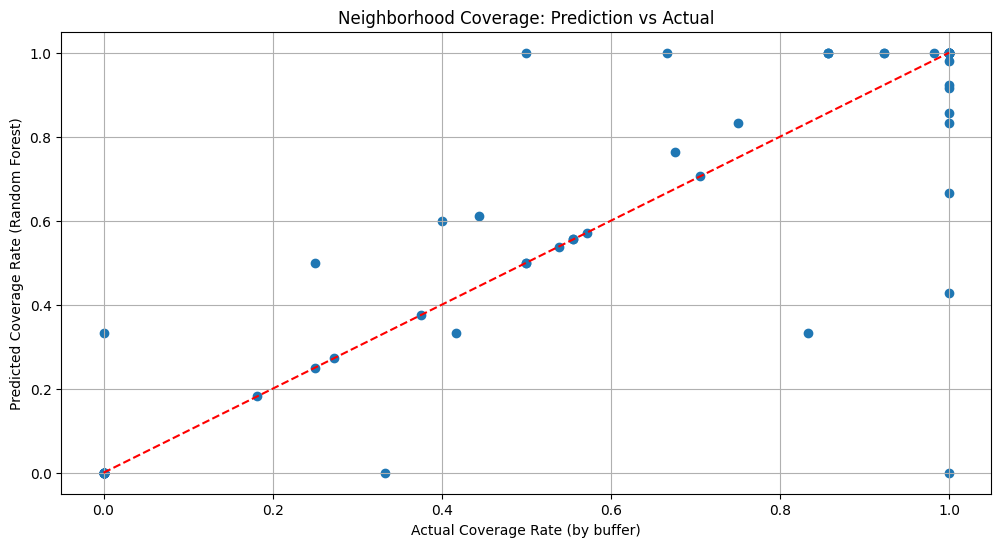

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(neigh_stats["actual_covered"], neigh_stats["predicted_covered"])
ax.plot([0, 1], [0, 1], "r--")
ax.set_xlabel("Actual Coverage Rate (by buffer)")
ax.set_ylabel("Predicted Coverage Rate (Random Forest)")
ax.set_title("Neighborhood Coverage: Prediction vs Actual")
plt.grid(True)
plt.show()
